In [1]:
import torch
import pandas as pd
import pyro
import pyro.distributions as dist
import posteriors
from tqdm import tqdm
import matplotlib.pyplot as plt

torch.manual_seed(42)

# Building Bayesian models with `pyro` and `posteriors`

In this notebook we'll use the probabilistic programming language `pyro` to define a Bayesian logistic regression model, then as [`pyro`](https://pyro.ai) is built on PyTorch we can convert the model into a log posterior function which can be used directly with `posteriors` for inference!

We'll also use the convergence diagnostics from `pyro` to check the convergence of the sampler (further demonstrating the ease of composability between the two libraries).

# Load the data

First up, let's load the Pima Indians dataset, which consists of 768 samples of 8 feature variables and a binary target variable (class).

In [2]:
# Load the Pima Indians Diabetes dataset
data_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = [
    "num_pregnant",
    "glucose_concentration",
    "blood_pressure",
    "skin_thickness",
    "serum_insulin",
    "bmi",
    "diabetes_pedigree",
    "age",
    "class",
]
data = pd.read_csv(data_url, header=None, names=column_names)

print(data.shape)

data.head()

(768, 9)


,num_pregnant,glucose_concentration,blood_pressure,skin_thickness,serum_insulin,bmi,diabetes_pedigree,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Now we'll normalise the features and load it into PyTorch tensors.

In [3]:
# Preprocess the data
X_all = data.drop(columns=["class"]).values
y_all = data["class"].values

# Normalize the data
X_mean = X_all.mean(axis=0)
X_std = X_all.std(axis=0)
X_all = (X_all - X_mean) / X_std

# Convert to torch tensors
X_all = torch.tensor(X_all, dtype=torch.float)
y_all = torch.tensor(y_all, dtype=torch.float)

num_data, dim = X_all.shape

# Define the model

We'll use a simple Bayesian logistic model $p(y = 1 | x) = \text{sigmoid}(x^T w)$, where $w \in \mathbb{R}^8$ is the weight vector and $x \in \mathbb{R}^8$ is vector containing the normalised features.

We'll use a normal prior on the weights $w \sim \mathcal{N}(0, 1)$ (note the rescaling to ensure normalization in the case of minibatching).

We'll use standard Pyro code to define the model.

In [4]:
def model(batch):
    X, y = batch

    batchsize = X.shape[0]

    # Define the priors
    w = pyro.sample(
        "w",
        dist.Normal(torch.zeros(X.shape[1]), scale=(num_data / batchsize) ** 0.5),
    )  # Scale to ensure the prior variance is 1 for all batch sizes

    # Define the logistic regression model
    logits = torch.matmul(X, w)
    y_pred = torch.sigmoid(logits)

    return pyro.sample("obs", dist.Bernoulli(y_pred), obs=y)

Then we can use `pyro.poutine` to convert the model into a log posterior function that can be passed to `posteriors`.

In [5]:
def log_posterior_normalized(params, batch):
    X, y = batch
    batchsize = X.shape[0]
    conditioned_model = pyro.condition(model, data={"w": params})
    model_trace = pyro.poutine.trace(conditioned_model).get_trace((X, y))
    log_joint = model_trace.log_prob_sum()
    return log_joint / batchsize, torch.tensor([])

Recall that `posteriors` recommends [log posteriors to be normalized by batchsize](https://normal-computing.github.io/posteriors/log_posteriors/) and return a tuple with [optional auxiliary information](https://normal-computing.github.io/posteriors/gotchas/#auxiliary-information).

# SGHMC with `posteriors` and convergence diagnostics with `pyro` 

Now let's use `posteriors` to perform HMC sampling with the above data and model.

We'll use the [`pyro` diagnostics](https://docs.pyro.ai/en/stable/ops.html) to examine convergence.

In [6]:
N_warmup = 2000
N_samples = 6000
N_steps = N_warmup + N_samples
initial_params = torch.zeros(X_all.shape[1])
num_chains = 5

In [7]:
transform = posteriors.sgmcmc.sghmc.build(
    log_posterior_normalized,
    lr=1e-2,
    temperature=1 / num_data,
    alpha=1.0,
)

In [8]:
states = [transform.init(initial_params) for _ in range(num_chains)]

In [9]:
log_posts = torch.zeros((num_chains, N_steps))
samples = torch.zeros((num_chains, N_steps, dim))
gelman_rubin = torch.zeros(N_samples)

for i in tqdm(range(N_steps)):
    states = [transform.update(state, (X_all, y_all))[0] for state in states]
    log_posts[:, i] = torch.stack([state.log_posterior for state in states])
    samples[:, i] = torch.stack([state.params for state in states])
    if i > N_warmup:
        j = i - N_warmup
        gelman_rubin[j] = pyro.ops.stats.gelman_rubin(log_posts[:, N_warmup:i + 1])


100%|██████████| 8000/8000 [00:22<00:00, 350.54it/s]


# Check convergence and plot marginals

Now let's examine our results!

First we'll look at the log posterior values

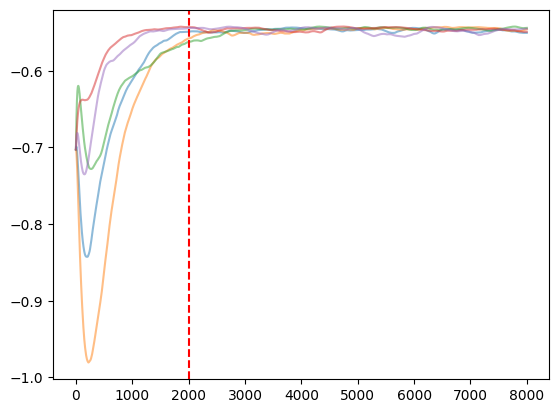

In [10]:
plt.plot(log_posts.T, alpha=0.5)
plt.axvline(N_warmup, color="red", linestyle="--");

All good so far!

Now we can look at the Rhat (Gelman-Rubin) statistic for the log posteriors values (which serves as a good univariate summary statistic as opposed to any individual dimension), which we calculated in the loop with `pyro`.

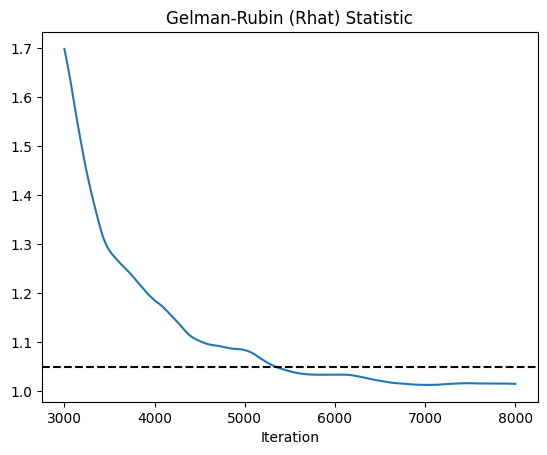

In [11]:
k = 1000
plt.plot(torch.arange(N_warmup + k, N_steps), gelman_rubin[k:])
plt.axhline(1.05, color="black", linestyle="--")
plt.title("Gelman-Rubin (Rhat) Statistic")
plt.xlabel("Iteration");

[According to the Stan documentation an Rhat of below 1.05 is considered good for convergence](https://mc-stan.org/rstan/reference/Rhat.html), so we're looking good!

Finally, we'll inspect the marginal distributions of the parameters to check nothing looks too crazy.

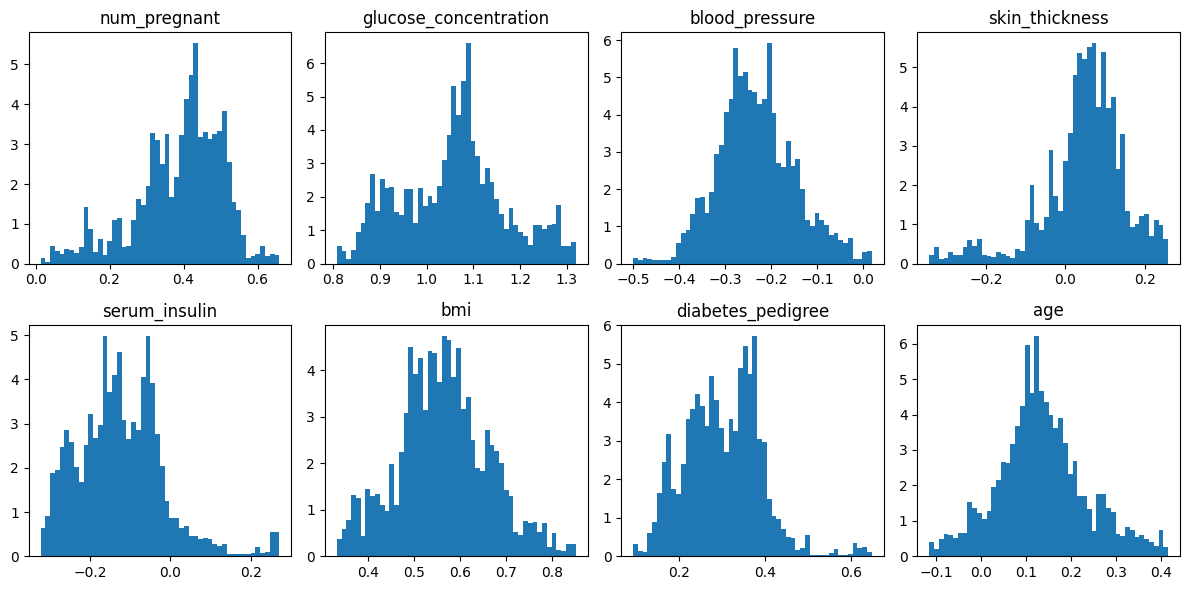

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for ind, ax in enumerate(axes.flatten()):
    ax.hist(samples[:, N_warmup:, ind].flatten(), bins=50, density=True)
    ax.set_title(column_names[ind])
fig.tight_layout()


This looks reasonable enough, as the samples are well distributed within their domains which are clearly removed from the initial value of 0.